# Functions

In [1]:
##############################
# NOTE: This will fail for large dataset processing or complex model evaluation
# Use the command below to run it in the background 
##############################
# Source: https://www.maksimeren.com/post/screen-and-jupyter-a-way-to-run-long-notebooks-headless/
# jupyter nbconvert --to notebook --execute capstone.template.ipynb --output=capstone.out.ipynb --ExecutePreprocessor.timeout=-1

##############################
# Library Imports
##############################
import copy
import json
import itertools
import math
import os
import io
from datetime import datetime
from random import randint
import timeit
import datetime

from IPython.core.getipython import get_ipython
from IPython.display import display, Markdown, Latex

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Frameworks
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import seaborn.objects as so


# Plotly
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# scikit-learn
from sklearn import metrics
from sklearn import set_config
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, mean_squared_error, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve, RocCurveDisplay, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

##############################
# Needed methods to bootstrap
##############################
def readFile(path, notFoundException=True):
    data = '';
    if os.path.exists(path):
        with open(path) as f: 
            data = f.read()
    elif notFoundException:
        raise Exception(f'{path} does not exist')
    return data

def readJson(path):
    data = readFile(path)
    return json.loads(data)

def writeString2File(string2Write, path, print2Screen = False):
    if print2Screen:
        print(string2Write)
    with open(path, "w") as text_file:
        text_file.write(str(string2Write))
##############################
# Configuration + Flow control
##############################
GRID_SEARCH_JOBS = 4
BEGIN_RUN_DATETIME = datetime.datetime.now()
SETTINGS = readJson('./settings.json')
EXECUTION_MODE = SETTINGS['mode']
DEV_MODE = "development" == EXECUTION_MODE
print(f'Execution mode: {EXECUTION_MODE}')
EXECUTION_START_TIME = timeit.default_timer()
RUNTIME_METRICS = {}

##############################
# Runtime Settings
##############################
set_config(display="diagram")
import warnings
warnings.filterwarnings('ignore')

##############################
# Constants
##############################
# https://seaborn.pydata.org/tutorial/color_palettes.html#sequential-color-palettes
MAIN_PALETTE_QUALITATIVE = 'pastel'
HIGHLIGHT_PALETTE_QUALITATIVE = 'Pastel2'
MAIN_PALETTE_SEQUENTIAL = 'crest'
IMAGE_DIR_SUFFIX = ''
INPUT_FILE = './data/all_tickets_processed_improved_v3.csv'
RESULT_DIR = f'./analysis_results'    
README_FILE = f'./README.md'
TARGET_FIELD = 'target'
DOCUMENT_FIELD = 'Original'
STEMMED_FIELD = 'Stemmed';
LEMMATIZED_FIELD = 'Lemmatized';
BOTH_FIELD = 'Stemmed and Lemmatized';
FIELDS_TO_PROCESS = [DOCUMENT_FIELD, STEMMED_FIELD, LEMMATIZED_FIELD, BOTH_FIELD]


VECTORIZERS_2_TRY = {
    'CountVectorizer': {
        'model': CountVectorizer(lowercase=True),
        'params': {
            'max_features': [None, 100, 250, 500]
        }
    },
    'TfidfVectorizer': {
        'model': TfidfVectorizer(lowercase=True),
        'params': {
            'max_features': [None, 100, 250, 500]
        }
    }
}
# LogisticRegression: For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
# ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from
# Test L2 separately because we're not going to scale the data
REGRESSORS_2_TRY = {
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            'max_depth': [10, 25, 50, 100, 250, 500]
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [10, 25, 100, 250, 500],
            'weights': ['uniform', 'distance']
        }
    },
    'MultinomialNB': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
        }
    },
    'ComplementNB': {
        'model': ComplementNB(),
        'params': {
            'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'penalty': ['elasticnet'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['saga'],
            'l1_ratio': np.linspace(0, 1, num=5)
        }
    }
}


if DEV_MODE:
    RESULT_DIR =  f'{RESULT_DIR}.{EXECUTION_MODE}'
    README_FILE = f'./README.{EXECUTION_MODE}.md'
    #FIELDS_TO_PROCESS = [DOCUMENT_FIELD, STEMMED_FIELD]
    VECTORIZERS_2_TRY['CountVectorizer']['params'] = { 'max_features': [100] }
    VECTORIZERS_2_TRY['TfidfVectorizer']['params'] = { 'max_features': [100] }
    REGRESSORS_2_TRY['LogisticRegression']['params'] = { 'penalty': ['elasticnet'] , 'C': [0.001, 0.01], 'solver': ['saga'],'l1_ratio': np.linspace(0, 1, num=3)}
    REGRESSORS_2_TRY['DecisionTreeClassifier']['params'] = { 'max_depth': [5, 10] }
    REGRESSORS_2_TRY['KNeighborsClassifier']['params'] = { 'n_neighbors': [10, 100], 'weights': ['uniform', 'distance']}
    REGRESSORS_2_TRY['MultinomialNB']['params'] = { 'alpha': [1, 0.1] }
    REGRESSORS_2_TRY['ComplementNB']['params'] = { 'alpha': [1, 0.1] }

RESULT_FILE_PREFIX = RESULT_DIR +'/capstone.'
IMAGE_PREFIX = RESULT_FILE_PREFIX

if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

def addMarkdownImage(name, path, asMarkdown=False):
    if asMarkdown:
        out = f'![{name}]({IMAGE_PREFIX}{path})'
    else:
        out = f'<a href="{IMAGE_PREFIX}{path}" target="_blank"><img src="{IMAGE_PREFIX}{path}"/></a>'

    return out


    
def writeTargetFieldDistributionDetails(data, targetField, fileNameSuffix, titleSuffix='', width=640, height=480, palette=MAIN_PALETTE_QUALITATIVE):
    useFileNameSuffix = fileNameSuffix
    if useFileNameSuffix.endswith("."):
        useFileNameSuffix = useFileNameSuffix[:-1]

    graphsPerRow = 1
    widthInches = width * graphsPerRow/100
    heightInches = height * 2/100
    palette2use = palette
    title = f'Data Distribution for {targetField} {titleSuffix}'
    
    plt.clf()
    fig = plt.figure(figsize=(widthInches, heightInches))
    #ax = sns.histplot(data=data, y=targetField, palette=palette2use, bins=bins, stat='percent')
    #labels = [str(round(v, 2)) if v else '' for v in ax.containers[1].datavalues]
    #ax.bar_label(ax.containers[1], labels=labels)
    
    #fig.suptitle(title)
    #fig.tight_layout()
    
    #create pie chart
    targetFieldValueCounts = data[targetField].value_counts()
    total = sum(targetFieldValueCounts.values)
    def my_fmt(x):
        return '{:.2f}% ({:.0f})'.format(x, total*x/100)
    colors = sns.color_palette(palette)
    patches, labels, pct_texts = plt.pie(targetFieldValueCounts, labels = targetFieldValueCounts.index, colors = colors, autopct=my_fmt, rotatelabels=True)
    for label, pct_text in zip(labels, pct_texts):
        pct_text.set_rotation(label.get_rotation())
    plt.title(title)
    fig.tight_layout()
    plt.savefig(IMAGE_PREFIX + useFileNameSuffix + '.targetField.distribution.png')
    #plt.show()

        
def writeDataFrameDetails(data, fileNameSuffix, writeInfo=False, writeDescribe=False):
    buffer = io.StringIO()
    data.info(verbose=True, buf=buffer, show_counts=True)
    useFileNameSuffix = fileNameSuffix
    if useFileNameSuffix.endswith("."):
        useFileNameSuffix = useFileNameSuffix[:-1]
    if writeInfo:
        writeString2File(buffer.getvalue(), RESULT_FILE_PREFIX + useFileNameSuffix + '.data.info.txt')
    if writeDescribe:
        writeString2File(data.describe(), RESULT_FILE_PREFIX + useFileNameSuffix + '.data.describe.txt')

    
def printDataFrameInfo(name, stage, showDescribe=True):
    out = ''
    out += f'### {name}\n\n'
    out += '<table>'
    out += '<tr><th>info()</th>'

    if showDescribe:
        out += '<th>describe()</th></tr>'

    prefix = RESULT_FILE_PREFIX + stage
    rawDfInfo = readFile(prefix + '.data.info.txt')
    rawDfDescribe = readFile(prefix + '.data.describe.txt')
    
    out += '<tr>'
    out += f'<td><pre>{rawDfInfo}</pre></td>'
    if showDescribe:
        out += f'<td><pre>{rawDfDescribe}</pre></td>'
    out += '</tr>'
    out += '</table>\n\n'

    return out

def writeDataFrame2Excel(inputDf, name):
    extension = '.dataFrame.xlsx'
    if name[-1] == '.':
        extension = 'dataFrame.xlsx'
    with pd.ExcelWriter(RESULT_FILE_PREFIX + name + extension) as writer:
        inputDf.to_excel(writer, index=False)

# NOTE: Need this to avoid value truncation in cells
pd.set_option('display.max_colwidth', None)
def dataFrame2Html(inputDf, path, print2Screen = False):
    string2write = inputDf.to_html(index=False)
    writeString2File(string2write, IMAGE_PREFIX + path + '.dataFrame.html', print2Screen)

def printReadMe(final=False, displayInline=False):
    noteBookContent = '## Research Code\n'
    noteBookContent += '**Code:** [Data Analysis Workbook](./capstone.out.ipynb)\n\n'
    noteBookContent += '**NOTE:** *The processing of the juypter notebook take a long time and often disconnects from the session. In order to run it without monitoring it all the time use the wokraround below from command line.*\n'
    noteBookContent += '```\n'
    noteBookContent += 'jupyter nbconvert --to notebook --execute {input_notebook} --output={output_notebook} --ExecutePreprocessor.timeout=-1\n'
    noteBookContent += '```\n'
    noteBookContent += '<sub>Source: [screen-and-jupyter-a-way-to-run-long-notebooks-headles](https://www.maksimeren.com/post/screen-and-jupyter-a-way-to-run-long-notebooks-headless/)</sub>\n\n'
    #noteBookContent += 'Jump to the good stuff: [Summary, Observations and Guidance](#next-steps-summary-observations-and-guidance)\n'
    
    readMeContent = ''
    readMeContent += readFile(RESULT_FILE_PREFIX + 'section01.md', notFoundException=False) + '\n\n'
    readMeContent += noteBookContent + '\n\n'
    readMeContent += readFile(RESULT_FILE_PREFIX + 'section02.md', notFoundException=False) + '\n\n'
    readMeContent += readFile(RESULT_FILE_PREFIX + 'section03.md', notFoundException=False) + '\n\n'
    readMeContent += readFile(RESULT_FILE_PREFIX + 'section04.md', notFoundException=False) + '\n\n'
    readMeContent += readFile(RESULT_FILE_PREFIX + 'section05.md', notFoundException=False) + '\n\n'
    readMeContent += readFile(RESULT_FILE_PREFIX + 'section06.md', notFoundException=False) + '\n\n'
    readMeContent += readFile(RESULT_FILE_PREFIX + 'section07.md', notFoundException=False) + '\n\n'
    readMeContent += readFile(RESULT_FILE_PREFIX + 'section08.md', notFoundException=False) + '\n\n'
    readMeContent += readFile(RESULT_FILE_PREFIX + 'section09.md', notFoundException=False) + '\n\n'
    readMeContent += readFile(RESULT_FILE_PREFIX + 'section10.md', notFoundException=False) + '\n\n'
    
    # Add metrics only do total on final write
    if final:
        RUNTIME_METRICS['start_time'] = f'{BEGIN_RUN_DATETIME}'
        RUNTIME_METRICS['end_time'] = f'{datetime.datetime.now()}'
        RUNTIME_METRICS['total_execution_time'] = timeit.default_timer() - EXECUTION_START_TIME
        
    jsonRuntimeMetrics = json.dumps(RUNTIME_METRICS, indent=2)
    reportingContent = ''
    reportingContent += f'# Runtime Metrics:\n'
    reportingContent += '```\n'
    reportingContent += f'{jsonRuntimeMetrics}\n'
    reportingContent += '```\n'
    readMeContent += reportingContent + '\n\n'

    writeString2File(readMeContent, README_FILE)
    if displayInline:
        display(Markdown(readMeContent))

Execution mode: production


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lloyd.gomes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/lloyd.gomes/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lloyd.gomes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lloyd.gomes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47837 entries, 0 to 47836
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Original  47837 non-null  object
 1   target    47837 non-null  object
dtypes: object(2)
memory usage: 747.6+ KB


<Figure size 640x480 with 0 Axes>

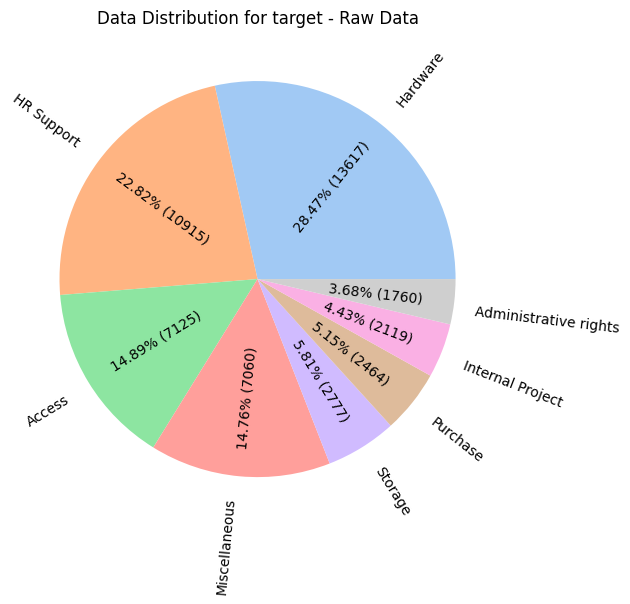

In [2]:
rawDf = pd.read_csv(INPUT_FILE)
rawDf = rawDf.rename(columns={"Document": DOCUMENT_FIELD, "Topic_group": TARGET_FIELD})
rawDf.info()
if(DEV_MODE):
    SAMPLE_PERCENT = 0.35
    rawDf = rawDf.groupby(TARGET_FIELD, group_keys=False).apply(lambda x: x.sample(frac=SAMPLE_PERCENT)) 
    rawDf.info()

writeDataFrameDetails(data=rawDf, fileNameSuffix='raw', writeInfo=True, writeDescribe=True)
writeTargetFieldDistributionDetails(data=rawDf, targetField=TARGET_FIELD, fileNameSuffix='raw', titleSuffix='- Raw Data')

# Overview

In [3]:
sectionIndex = 1

content = '# Capstone: IT Service Ticket Classification\n'
content += '<b color="red">NOTE: All images are clickable and higher resolution images will load in new browser window</b>\n'
content += '## Background\n'

content += 'Most companies have a service desk to help their user or customers with their IT problems.\n'
content += 'Customers log and track their ticket in some digital platform and these get routed to Agents to solve.\n'
content += 'Routing these tickets to the correct person/team to solve is very important:\n'
content += '- A common approach is to "tag" the ticket with some classification and there is a mapping that routes based on the tag to the correct team to solve it.\n'
content += '- Tickets incorrectly classified result in them "bouncing around" and wasting both agents and customer time.\n'
content += '- There is a financial impact resulting in wasted internal resources and lower customer satisfaction costing the company in real world dollars as well as reputation.\n'
content += '- The scale of the problem grows as you service more users as you need more and more agents to help.\n'
content += '\n\n'
content += 'This project aims to address this task by finding and building a model to aid in the classification of these tickets into appropriate categories. We will experiment with various types of pre-processing, vectorizers and regression models to help us find the best one to solve for this.\n\n'

content += '**Dataset**: [IT Service Ticket Classification Dataset](https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset)\n'
content += '- This dataset contains 47,837 rows of data and 2 features.\n\n'
content += 'We will follow the CRISP-DM process model consisting of Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation, Deployment stages.\n'
sectionStr = str(sectionIndex).zfill(2)
writeString2File(content, RESULT_FILE_PREFIX + f'section{sectionStr}.md')
printReadMe()

# CRISP-DM: Business Understanding

In [4]:
sectionIndex = 2

content = '## Business Understanding\n'
content += 'Our goal is to:\n'
content += '- Come up with the best classification model to correctly classify the tickets based solely on the description.\n'
content += '- Provide the business with the best model and hyperparameters to drive the best accuracy.\n'
content += '- Provide the business with alternative models trading accuracy for performance in case that may be a concern or to scale for a much larger dataset that may need re-training.\n'
sectionStr = str(sectionIndex).zfill(2)
writeString2File(content, RESULT_FILE_PREFIX + f'section{sectionStr}.md')
printReadMe()

# CRISP-DM: Data Understanding

In [5]:
sectionIndex = 3

content = '## Data Understanding\n'
content += '### Data Shape\n'
content += printDataFrameInfo('Raw', 'raw', showDescribe=False)

content += '### Features\n'
content += f'- There is only one feature {DOCUMENT_FIELD} which is free form text\n'
content += '- There are no missing values\n'
content += '- All data appears to be in english\n'
content += '- All data appears to be lowercased\n'
content += '- The data set is somewhat large and the classes are imbalanced.\n'
uniqueValues = len(rawDf[TARGET_FIELD].value_counts().values)
content += f'- The classification field {TARGET_FIELD} has {uniqueValues} distinct values\n'
imgPath = 'raw.targetField.distribution.png'
rawDfStatsImage = addMarkdownImage('Classification Field Data Distribution', f'{imgPath}')
content += rawDfStatsImage + '\n\n'

sectionStr = str(sectionIndex).zfill(2)
writeString2File(content, RESULT_FILE_PREFIX + f'section{sectionStr}.md')
printReadMe()

# CRISP-DM: Data Preparation

<Figure size 640x480 with 0 Axes>

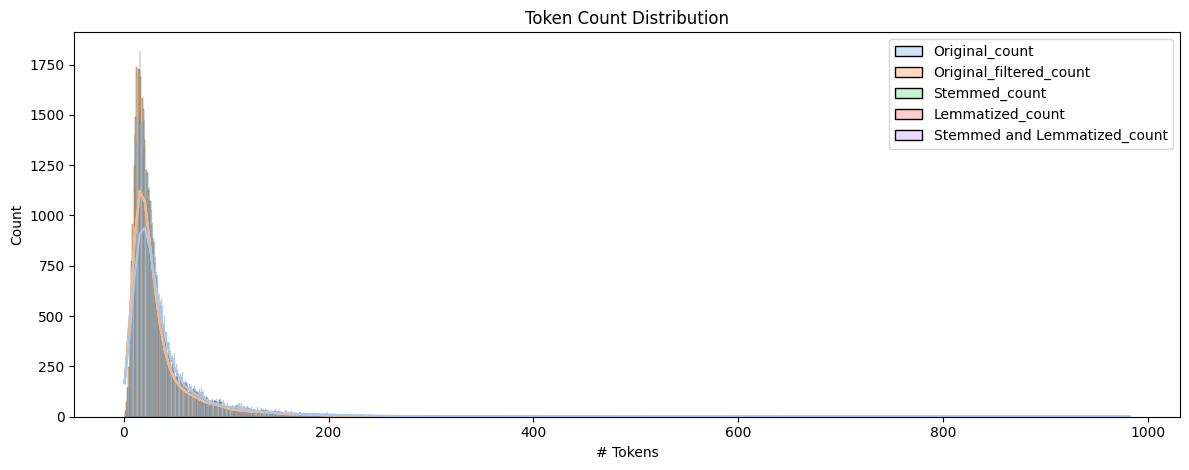

In [6]:
sectionIndex = 4

subMetricNodeName = 'pre_processing';
subMetricNode = {}
RUNTIME_METRICS[subMetricNodeName] = subMetricNode

stop_words = set(stopwords.words('english'))

def preProcess(row):
    text = row[DOCUMENT_FIELD];
    textArray = [w for w in word_tokenize(text)]
    textCount = len(textArray)
    row[DOCUMENT_FIELD + '_count'] = textCount

    noStopWordsTextArray = [w for w in textArray if not w.lower() in stop_words]
    row[DOCUMENT_FIELD + '_filtered_count'] = len(noStopWordsTextArray)
    
    
    stem = PorterStemmer()
    stemArray = [stem.stem(w) for w in noStopWordsTextArray]
    stemText =  ' '.join(stemArray)
    row[STEMMED_FIELD + '_count'] = len(stemArray)
    row[STEMMED_FIELD] = stemText

    
    lemma = WordNetLemmatizer()
    lemmaArray = [lemma.lemmatize(w) for w in noStopWordsTextArray]
    lemmaText =  ' '.join(lemmaArray)
    row[LEMMATIZED_FIELD + '_count'] = len(stemArray)
    row[LEMMATIZED_FIELD] = lemmaText

    both = WordNetLemmatizer()
    bothArray = [both.lemmatize(w) for w in word_tokenize(stemText)]
    bothText =  ' '.join(bothArray)
    row[BOTH_FIELD + '_count'] = len(bothArray)
    row[BOTH_FIELD] = bothText 
    
    return row

experimentDf = rawDf.copy()

startTime = timeit.default_timer()
experimentDf = experimentDf.apply(preProcess, axis=1)
#display(experimentDf.head())
subMetricNode['total_time'] = timeit.default_timer() - startTime


plt.clf()
fig = plt.figure(figsize=(12, 4.8))
countFields = [DOCUMENT_FIELD + '_count', DOCUMENT_FIELD + '_filtered_count', STEMMED_FIELD + '_count', LEMMATIZED_FIELD + '_count', BOTH_FIELD + '_count', TARGET_FIELD]

ax = sns.histplot(data=experimentDf[countFields], palette='pastel', kde=True)
ax.set_title('Token Count Distribution')
# ax.set_ylabel('Model + Vectorizer')
ax.set_xlabel('# Tokens')
# for i in ax.containers:
#     ax.bar_label(i,label_type='edge')
# sns.move_legend(ax, legendLocation, bbox_to_anchor=bboxAnchor)
fig.tight_layout()
plt.savefig(IMAGE_PREFIX + 'pre_process.token_count_distribution.png')
#plt.show()


content = '## Data Preparation\n'
content += '### Pre-Processing Decisions\n'
content += '- We will need to:\n'
content += '  - lowercase the data\n'
content += '  - remove stop words\n'
content += '  - stem, lemmatize or combination of both\n'
content += '- We will create three columns for variations of stem, lemmatize, stem+lemmatize and then run through models to evaluate which is best\n'
content += "  - I am opting to do this here because while normally we would bake this into the Pipeline since we are experimenting I want to optmize the process and just process these once instead of each time we switch the model during cross validation stage."
content += addMarkdownImage('Token Distribution', 'pre_process.token_count_distribution.png') + '\n\n'
content += '### Analysis\n'
content += "- It is interesting to note both looking at the data and the distribution plot of tokens which doesn't appear to shift much after pre-processing that the data has been through some level of pre-processing already.\n"
content += "- Once pre-processing is done a majority of the tokens fall below 200 we can use this to set the upper bound for some of the model hyperparameters.\n"

sectionStr = str(sectionIndex).zfill(2)
writeString2File(content, RESULT_FILE_PREFIX + f'section{sectionStr}.md')
printReadMe()

# CRISP-DM: Modeling

,target
0,Hardware
1,HR Support
2,Hardware
3,Access
4,Miscellaneous
...,...
14347,Access
14348,Hardware
14349,Access
14350,Hardware


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

<Figure size 640x480 with 0 Axes>

<Figure size 640x960 with 0 Axes>

<Figure size 640x960 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

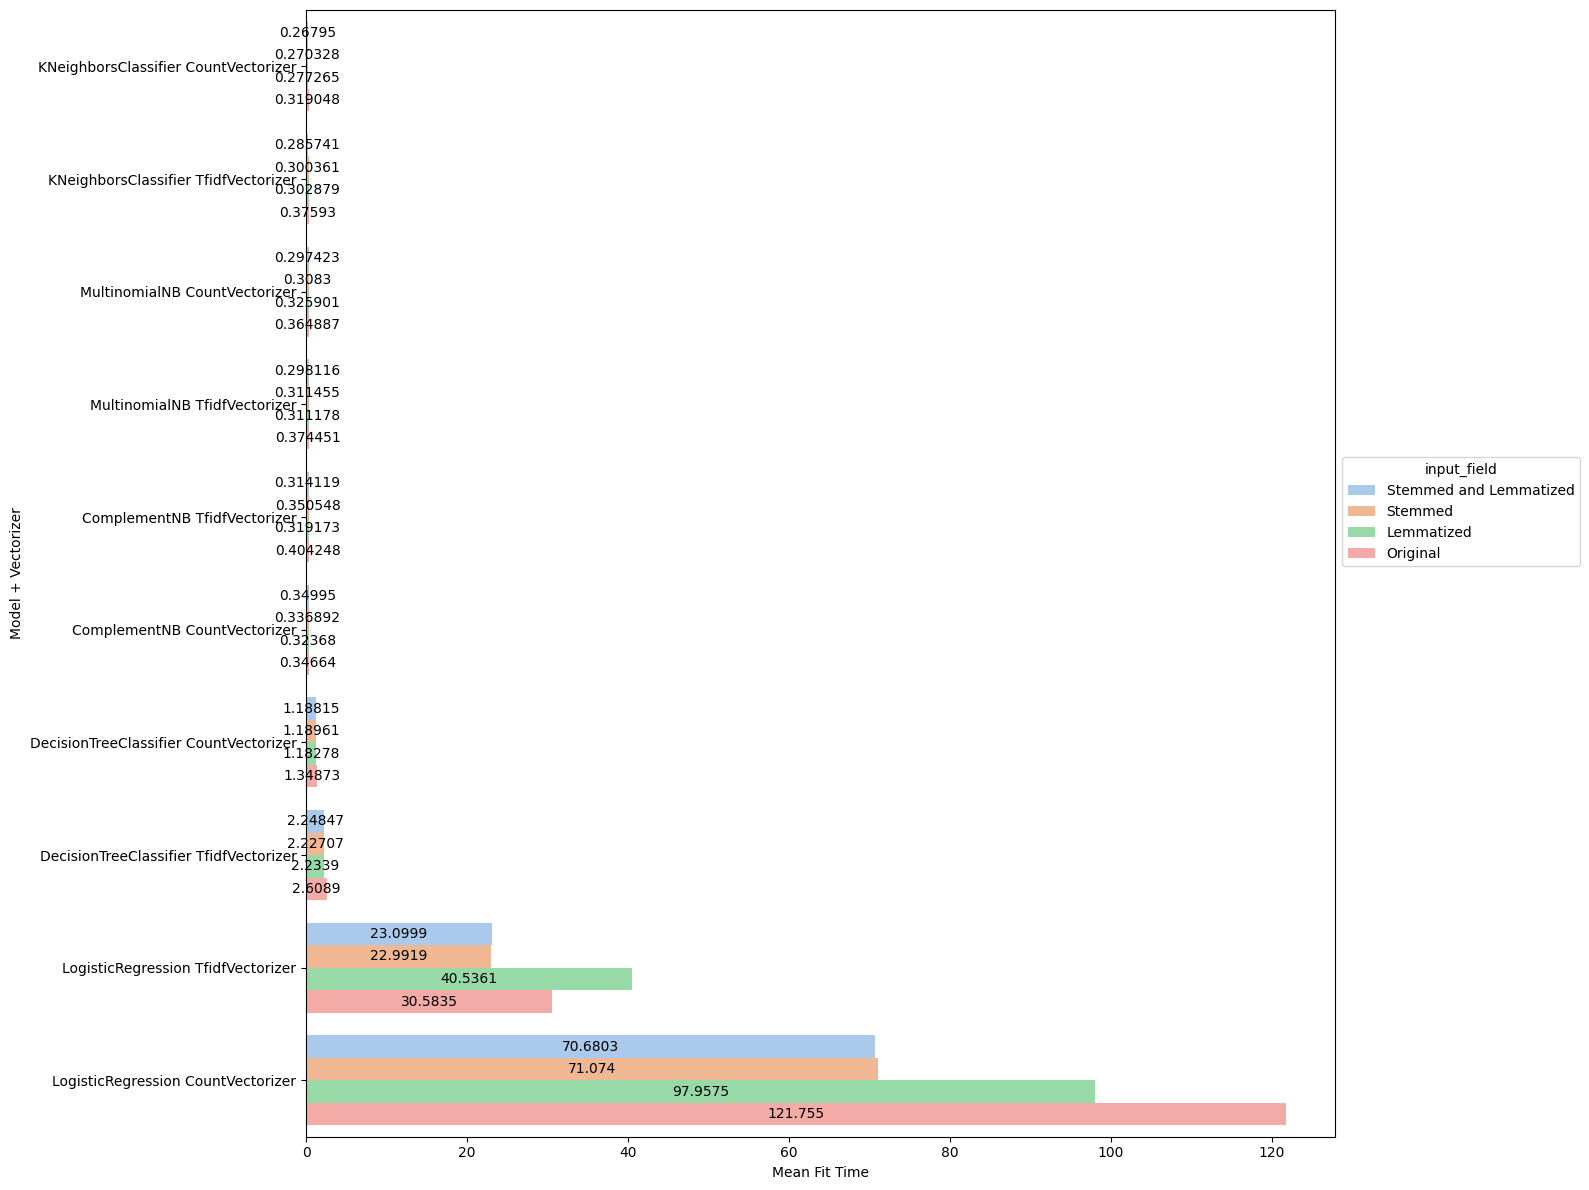

In [7]:
sectionIndex = 5

subMetricNodeName = 'modeling';
subMetricNode = {}
RUNTIME_METRICS[subMetricNodeName] = subMetricNode
startTime = timeit.default_timer()

#display(experimentDf.head())
X = experimentDf[FIELDS_TO_PROCESS]
y = experimentDf[TARGET_FIELD]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

yTrainDf = pd.DataFrame({TARGET_FIELD: y_train.values})
yTestDf = pd.DataFrame({TARGET_FIELD: y_test.values})
display(yTestDf)
writeTargetFieldDistributionDetails(data=yTrainDf, targetField=TARGET_FIELD, fileNameSuffix='model_results.y_train', titleSuffix='- Train')
writeTargetFieldDistributionDetails(data=yTestDf, targetField=TARGET_FIELD, fileNameSuffix='model_results.y_test', titleSuffix='- Test')

#point at reportDf for now so we can update for long run
def dumpIntermediateReport(reportDf):
    # Dump results after each run so easier to track progress over long run
    writeDataFrame2Excel(reportDf, 'model_results')
    #print(reportDf)
    subMetricNode['total_time'] = timeit.default_timer() - startTime
    
    content = '## Modeling\n'
    content += '### Feature Engineering Decisions\n'
    content += '- No real feature engineering is needed as we have no missing data and nothing to impute. The preprocessing takes care of most of the needs for stemming and lemmatization before our modeling stage.\n'
    content += '- When creating intial train and test sets (30% of data for testing) we will stratify the set so that both train and test sets contain similar percentages of the classes because they are imbalanced.\n'
    content += '- When we do our grid search split because the target classes are imbalanced we will use StratifiedKFold so the splits are representative of the orginal set and class balances.\n'
    content += '- We will try the following models:\n'
    content += '  - LogisticRegression: We will use elasticnet since it intergates l1 and l2 penalties rather than having to pick between ridge and lasso.\n'
    content += '  - Decision Tree: While not expecting the best performance a decision tree could help us in explainability of how a decision is made and derive important "features/tokens"\n'
    content += '  - Naive Bayes: We will use Multinomail and Complement. Complement is meant to deal better with imbalanced classes but we shall see.\n'
    content += '  - KNN: Will use k nearest neigbhours, one would expect that tickets in the same category would have similar words and so would cluster well together\n'
    
    content += '\n'
    content += '### Data Distribution\n'
    content += 'Checking to make sure our test and train datasets represent the class imbalances\n'
    content += '<table>\n'
    content += '<tr>\n'
    content += '<td>\n'
    content += addMarkdownImage('Class Distribution - Train', 'model_results.y_train.targetField.distribution.png')
    content += '</td>\n'
    content += '<td>\n'
    content += addMarkdownImage('Class Distribution - Train', 'model_results.y_test.targetField.distribution.png')
    content += '</td>\n'
    content += '</tr>\n'
    content += '</table>\n\n'
    
    dataDf = pd.read_excel(RESULT_FILE_PREFIX + 'model_results.dataFrame.xlsx')
    
    copyDf = dataDf.copy()
    dataDf['pipeline'] = dataDf.apply(lambda row: (row['model'] + ' ' + row['vectorizer']), axis=1)
    
    #display(dataDf.head())
    
    legendLocation='lower left'
    bboxAnchor=(1, 0.5)
    
    dataDf = dataDf.sort_values('best_score', ascending=False)
    plt.clf()
    fig = plt.figure(figsize=(16, 12))
    ax = sns.barplot(data=dataDf, y='pipeline', x='best_score', hue='input_field', palette='pastel')
    ax.set_title('Model + Vectorizer vs Accuracy')
    ax.set_ylabel('Model + Vectorizer')
    ax.set_xlabel('Accuracy')
    for i in ax.containers:
        ax.bar_label(i,label_type='center')
    sns.move_legend(ax, legendLocation, bbox_to_anchor=bboxAnchor)
    fig.tight_layout()
    plt.savefig(IMAGE_PREFIX + 'model_results.accuracy.png')
    #plt.show()
    
    dataDf = dataDf.sort_values('mean_fit_time', ascending=True)
    plt.clf()
    fig = plt.figure(figsize=(16, 12))
    ax = sns.barplot(data=dataDf, y='pipeline', x='mean_fit_time', hue='input_field', palette='pastel')
    ax.set_ylabel('Model + Vectorizer')
    ax.set_xlabel('Mean Fit Time')
    for i in ax.containers:
        ax.bar_label(i,label_type='center')
    sns.move_legend(ax, legendLocation, bbox_to_anchor=bboxAnchor)
    fig.tight_layout()
    plt.savefig(IMAGE_PREFIX + 'model_results.fit_time.png')
    #plt.show()
    
    content += '### Model Results\n'
    headers = {
        'selector': 'th',
        'props': 'font-size: 8pt; font-family: Verdana;'
    }
    
    html = (
        copyDf.style
        .set_properties(**{'font-size': '8pt', 'font-family': 'Verdana'})
        .set_table_styles([headers])
        .hide(axis="index")
        .highlight_max(axis=0, subset=['best_score'], props='font-weight:bold; background-color:#CCE0AC;')
        .highlight_min(axis=0, subset=['best_score'], props='font-weight:bold; background-color:#FF8A8A;')
        .highlight_min(axis=0, subset=['mean_fit_time'], props='font-weight:bold; background-color:#CCE0AC;')
        .highlight_max(axis=0, subset=['mean_fit_time'], props='font-weight:bold; background-color:#FF8A8A;')
        .render()
    )
    #content += copyDf.to_html(index=False) + '\n\n'
    content += html + '\n\n'
    
    content += '### Analysis\n'
    content += '<table>\n'
    content += '<tr>\n'
    content += '<th>Accuracy</th>\n'
    content += '<th>Fit Time</th>\n'
    content += '</tr>\n'
    
    content += '<tr>\n'
    content += '<td>' + addMarkdownImage('Model Accuracy', 'model_results.accuracy.png') + '</td>\n'
    content += '<td>' + addMarkdownImage('Model Fit Time', 'model_results.fit_time.png') + '</td>\n'
    content += '</tr>\n'
    
    
    def printPerf(prefix, data, sortField, ascending=False):
        data = data.sort_values(sortField, ascending=ascending)
        checkFieldValue = data.iloc[0][sortField]
    
        nodes = data.loc[data[sortField] == checkFieldValue]
        out = ''
        if nodes.shape[0] == 1:
            for i, row in nodes.iterrows():
                currModel = row['model']
                currVectorizer = row['vectorizer']
                currScore = row['best_score'] * 100
                currParams = row['best_params']
                currFitTime = row['mean_fit_time']
                currInputField = row['input_field']
                out += f'{prefix} {currModel} with vectorizer {currVectorizer} with input pre-processing {currInputField} had accuracy score {currScore}% and mean fit time of {currFitTime} seconds.'
        else :
            out += f'{prefix}\n<ul>\n'
            for i, row in nodes.iterrows():
                currModel = row['model']
                currVectorizer = row['vectorizer']
                currScore = row['best_score'] * 100
                currParams = row['best_params']
                currFitTime = row['mean_fit_time']
                currInputField = row['input_field']
                out += f'<li> {currModel} with vectorizer {currVectorizer} with input pre-processing {currInputField} had accuracy score {currScore}% and mean fit time of {currFitTime} seconds.</li>'
            out += '</ul>\n'
        return out;
        
    content += '<tr>\n'
    content += '<td><ul>\n'
    content += '<li>' + printPerf('The best model was:\n', copyDf, 'best_score', False) + '</li>'
    content += '<li>' + printPerf('The worst model was:\n', copyDf, 'best_score', True) + '</li>'
    content += '</ul></td>\n'
    content += '<td><ul>\n'
    content += '<li>' + printPerf('The fastest model was:\n', copyDf, 'mean_fit_time', True) + '</li>'
    content += '<li>' + printPerf('The slowest model was\n', copyDf, 'mean_fit_time', False) + '</li>'
    content += '</ul></td>\n'
    content += '</tr>\n'
    
    content += '</table>\n\n'
    
    sectionStr = str(sectionIndex).zfill(2)
    writeString2File(content, RESULT_FILE_PREFIX + f'section{sectionStr}.md')
    printReadMe()

#print(y_train.value_counts(normalize=True))
#print(y_test.value_counts(normalize=True))
reportDf = pd.DataFrame(columns=['model', 'vectorizer', 'input_field', 'best_score', 'mean_fit_time', 'best_params', 'run_time'])
for mk in REGRESSORS_2_TRY:
    model = REGRESSORS_2_TRY[mk]
    modelParams = model['params']
    modelUsed = f'{mk}'
    modelMetricNode = {}
    modelStartTime = timeit.default_timer()
    subMetricNode[mk] = modelMetricNode
    for vk in VECTORIZERS_2_TRY:
        vectorizer = VECTORIZERS_2_TRY[vk]
        vectorizerUsed = f'{vk}'
        vectorizerParams = vectorizer['params']
        vectorMetricNode = {}
        vectorizerStartTime = timeit.default_timer()
        modelMetricNode[vk] = vectorMetricNode
        pipeline = Pipeline([
            ('vectorizer', vectorizer['model']),
            ('model', model['model'])
        ])
        finalParams = {}
        for k in vectorizerParams:
            finalParams['vectorizer__' + k] = vectorizerParams[k]

        for k in modelParams:
            finalParams['model__' + k] = modelParams[k]

        for f in FIELDS_TO_PROCESS:
            fieldMetricNode = {}
            vectorMetricNode[f] = fieldMetricNode
            experimentStartTime = timeit.default_timer()
            #cv = StratifiedKFold(n_splits=5, shuffle=True) # Not needed as per documentation
            # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, 
            # StratifiedKFold is used. In all other cases, KFold is used. These splitters are instantiated with 
            # shuffle=False so the splits will be the same across calls.
            grid = GridSearchCV(pipeline, param_grid=finalParams, n_jobs=GRID_SEARCH_JOBS)
            inputDf = X_train[f]
            testDf = X_test[f]
            grid.fit(inputDf, y_train)
            #print(grid.cv_results_)
            bestAccuracyScore = grid.score(testDf, y_test)
            bestParams = json.dumps(grid.best_params_)
            meanFitTime = np.mean(grid.cv_results_['mean_fit_time'])
            runTime = timeit.default_timer() - experimentStartTime
            fieldMetricNode['total_time'] = runTime
            reportDf.loc[reportDf.shape[0]] = [modelUsed, vectorizerUsed, f, bestAccuracyScore, meanFitTime, bestParams, runTime]

            dumpIntermediateReport(reportDf)
        vectorMetricNode['total_time'] =  timeit.default_timer() - vectorizerStartTime
    modelMetricNode = timeit.default_timer() - modelStartTime

# Read back in the final report
dataDf = pd.read_excel(RESULT_FILE_PREFIX + 'model_results.dataFrame.xlsx')

# CRISP-DM: Evaluation

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<Figure size 640x480 with 0 Axes>

<Figure size 640x640 with 0 Axes>

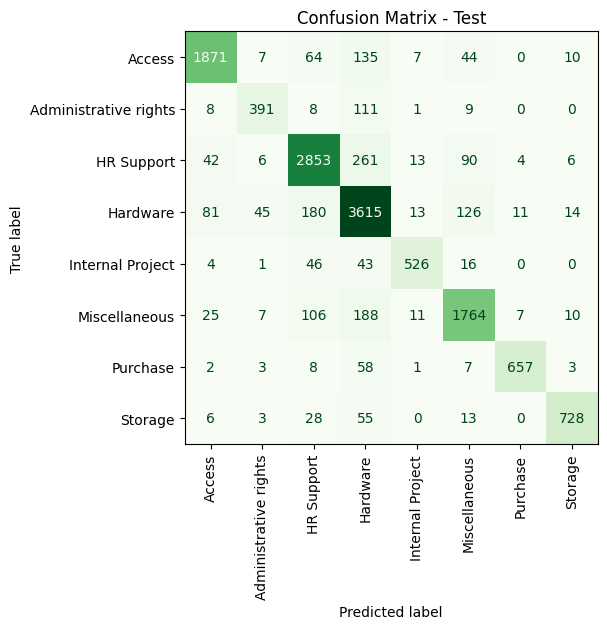

In [8]:
sectionIndex = 6

# Now take the best model and calculate the confusion matrix
dataDf = dataDf.sort_values('best_score', ascending=False)
bestScore = dataDf.iloc[0]['best_score']
bestModel = dataDf.iloc[0]['model']
bestVectorizer = dataDf.iloc[0]['vectorizer']
bestParams = dataDf.iloc[0]['best_params']
bestInputField = dataDf.iloc[0]['input_field']

model = REGRESSORS_2_TRY[bestModel]
vectorizer = VECTORIZERS_2_TRY[bestVectorizer]
pipeline = Pipeline([
    ('vectorizer', vectorizer['model']),
    ('model', model['model'])
])

finalParams = json.loads(bestParams)
for x in finalParams:
    value = finalParams[x]
    finalParams[x] = [value]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
grid = GridSearchCV(pipeline, param_grid=finalParams, n_jobs=GRID_SEARCH_JOBS)
grid.fit(X_train[bestInputField], y_train)
y_pred_train_final = grid.best_estimator_.predict(X_train[bestInputField])
y_pred_test_final = grid.best_estimator_.predict(X_test[bestInputField])


plt.clf()
fig, ax = plt.subplots(1, 1, squeeze=False)
fig.set_size_inches(6.4, 6.4)
ax[0,0].set_title('Confusion Matrix - Train')
ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_train[bestInputField], y_train, xticks_rotation='vertical', colorbar=False, cmap='Blues', ax=ax[0,0])
fig.tight_layout()
plt.savefig(IMAGE_PREFIX + 'evaluation.confusion_matrix.train.png')
#plt.show()



plt.clf()
fig, ax = plt.subplots(1, 1, squeeze=False)
fig.set_size_inches(6.4, 6.4)
ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_test[bestInputField], y_test, xticks_rotation='vertical', colorbar=False, cmap='Greens', ax=ax[0,0])
ax[0,0].set_title('Confusion Matrix - Test')
fig.tight_layout()
plt.savefig(IMAGE_PREFIX + 'evaluation.confusion_matrix.test.png')
#plt.show()



content = '## Evaluation\n'
content += f'We will now run our best pipeline which had an accuracy score of {bestScore * 100:.2f}%:\n'
content += f'- Preprocessing={bestInputField}\n'
content += f'- Vectorizer={bestVectorizer}\n'
content += f'- Model={bestModel} ({bestParams})\n\n'

content += '### Results\n'
content += '<table>\n'
content += '<tr>\n'
content += f'<th></th>\n'
content += f'<th>Train</th>\n'
content += f'<th>Test</th>\n'
content += '</tr>\n'
content += '<tr>\n'
content += f'<td>Classification Report</td>\n'
content += '<td>\n\n'
content += '```\n\n'
content += classification_report(y_train, y_pred_train_final) + '\n'
content += '```\n\n'
content += '</td>\n'
content += '<td>\n\n'
content += '```\n\n'
content += classification_report(y_test, y_pred_test_final) + '\n'
content += '```\n\n'
content += '</td>\n'
content += '</tr>\n'
content += '<tr>\n'
content += f'<td>Confusion Matrix</td>\n'
content += '<td>\n\n'
content += addMarkdownImage('Confusion Matrix - Train', 'evaluation.confusion_matrix.train.png') 
content += '</td>\n'
content += '<td>\n\n'
content += addMarkdownImage('Confusion Matrix - Test', 'evaluation.confusion_matrix.test.png') 
content += '</td>\n'
content += '</tr>\n'
content += '</table>\n\n'

sectionStr = str(sectionIndex).zfill(2)
writeString2File(content, RESULT_FILE_PREFIX + f'section{sectionStr}.md')
printReadMe()

# CRISP-DM: Deployment, Next Steps

In [9]:
sectionIndex = 7
content = '## Deployment and Future Work\n'
content += '### Observations\n'
content += '- We got lucky with this dataset and the data seemed to have some level of preprocessing (unclear based on documentation) done for us but lowercasing and removing stop words is a must.\n'
content += f'- {bestInputField} helped with accuracy. It seems like stemming adds the most benefit and adding lemmatization adds marginal benefit.\n'
content += f'- The {bestVectorizer} paired with models performs best. However, the cost seems negligible for the accuracy gain.\n'
content += '- It is very clear that The Naive Bayes models perform well in terms of tradeoffs for accuracy and speed.\n'
content += '### Model/Pipeline Selection\n'
content += f'- Given the choice if we want to maximize accuracy we would pick our best pipeline which had an accuracy score of {bestScore * 100:.2f}%:\n'
content += f'  - Preprocessing={bestInputField}\n'
content += f'  - Vectorizer={bestVectorizer}\n'
content += f'  - Model={bestModel} ({bestParams})\n\n'
content += f'- In general if we want a model capable of dealing with larger sets where training time is a concern and we can trade off on accuracy I would go with:\n'
content += f'  - Complement Naive Bayes as industry expectation is the data will be imbalanced for IT tickets.\n'
content += '### Next Steps\n'
content += 'Deep learning may be able get us even better results. This would be worth researching.\n\n'

sectionStr = str(sectionIndex).zfill(2)
writeString2File(content, RESULT_FILE_PREFIX + f'section{sectionStr}.md')
printReadMe()

In [10]:
# Do final printout
printReadMe(final=True)